<a href="https://www.inove.com.ar"><img src="https://lh3.googleusercontent.com/pw/ACtC-3ekLfw0AsoodcZkIONBznVKnsM7SsYW-qx66kYaiTAsZ5TZ0_lNLxuRqJWiuuL6j0UwjKa_ArO89y74bcX0GARWYhJMA04Soox_OYmNOohb9_NE2zwAYK7KMOtAj8tDowysed7ergBwBThxGU2epAm8=w1366-h239-no?authuser=0" width="1000" align="center"></a>
<h1><center>Clasificador de stress automático con Machine Learning</center></h1>
<h4>Sobre este ejemplo</h4>
Este proyecto presenta un sistema de Machine Learning realizado en Python para crear un sistema de monitoreo de stress, a partír de datos obtenidos de dispositivos como monitores de actividad física.

Con la creciente popularidad de los rastreadores que monitorean las señales biológicas las 24 horas del día, los 7 días de la semana, es solo una cuestión de tiempo antes de que la tecnología madure y todos llevarán su propia "IA médica" en la muñeca, este proyecto es un paso en esa dirección.

* [LINK](https://github.com/chriotte/Stress_classifier_with_AutoML_and_wearable_devices/blob/master/auto_ml_stress_simplified_notebook.ipynb) del trabajo realizado por Christopher Ottesen. 


In [ ]:
# Instalamos dependencias
!pip3 install tpot
!pip install -U kaleido
!!wget -O gibioplot.py https://raw.githubusercontent.com/HectorInove/gibioplot/master/gibioplot.py

Requirement already up-to-date: kaleido in /usr/local/lib/python3.6/dist-packages (0.0.3.post1)


['--2020-09-28 18:51:36--  https://raw.githubusercontent.com/HectorInove/gibioplot/master/gibioplot.py',
 'Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...',
 'Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.',
 'HTTP request sent, awaiting response... 200 OK',
 'Length: 5645 (5.5K) [text/plain]',
 'Saving to: ‘gibioplot.py’',
 '',
 '',
 'gibioplot.py          0%[                    ]       0  --.-KB/s               ',
 'gibioplot.py        100%[===================>]   5.51K  --.-KB/s    in 0s      ',
 '',
 '2020-09-28 18:51:36 (47.1 MB/s) - ‘gibioplot.py’ saved [5645/5645]',
 '']

In [ ]:
# Importamos librerías
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal 
import pickle
import sklearn.metrics
from sklearn.model_selection import cross_val_score
from sklearn import svm
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support 
import gibioplot as gp

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



# Recolectar datos
<div align="center"><img src="https://lh3.googleusercontent.com/pw/ACtC-3dp4dMGFr2D00UyD0240fBNyrzptD5onOf1wkHioTvEo-RpDmNEP61ssGPS4IiSKtDEwUHaU8krqeFZi3mjkiQDE72dtJy9zxptu48TYzfnbQp-O1WFZ0LFaXDG-jIz01IQyw2fZJzEFhnk_zK-glgP=w1366-h133-no?authuser=0" width="1000" align="middle"></div>
Descargamos los distintos datasets brindados en el repositorio


In [ ]:
# primero preguntamos si ya existe en nuestro dominio, sino, lo descargamos
try:
  f = open("/content/Stress_classifier_with_AutoML_and_wearable_devices/dataset/dataframe_hrv.csv")
  f.close()
  print('Dataset importado...')
except:
    !git clone https://github.com/InoveProyectos/Stress_classifier_with_AutoML_and_wearable_devices.git
    print('Dataset importado...')

# Realizamos la lectura de un dataframe
csv_path = '/content/Stress_classifier_with_AutoML_and_wearable_devices/dataset/dataframe_hrv.csv'
dataframe_hrv = pd.read_csv(csv_path)
dataframe_hrv = dataframe_hrv.reset_index(drop=True)

# Imprimimos para mirar un poco de que se trata
print('¡Echemos un vistazo a las primeras 5 filas!')
display(dataframe_hrv.head(5))

Dataset importado...
¡Echemos un vistazo a las primeras 5 filas!


,ECG,EMG,HR,RESP,Seconds,footGSR,handGSR,interval in seconds,marker,newtime,stress,time,NNRR,AVNN,SDNN,RMSSD,pNN50,TP,ULF,VLF,LF,HF,LF_HF
0,-0.001974,-0.004737,77.815789,10.801842,12.529684,2.417132,10.889447,0.614632,NaN,12.529684,0.0,12.529684,0.973684,0.617297,3.558630e-02,0.015203,0.055556,0.001238,0.0,0.000696,0.000407,0.000135,3.00200
1,0.002935,-0.004457,101.978261,10.750609,30.503500,2.417109,11.251065,0.647826,NaN,30.503500,0.0,30.503500,0.978261,0.647889,1.354660e-02,0.013858,0.045455,0.000144,0.0,0.000009,0.000060,0.000075,0.79371
2,0.006745,-0.003426,104.957447,10.557234,52.523021,2.226872,11.379638,0.646383,NaN,52.523021,0.0,52.523021,0.978723,0.645000,2.240000e-08,0.000000,0.000000,NaN,0.0,NaN,NaN,NaN,NaN
3,-0.004043,-0.002532,87.702128,10.640128,74.402170,2.173021,11.470830,0.645000,NaN,74.402170,0.0,74.402170,0.978723,0.645000,2.240000e-08,0.000000,0.000000,NaN,0.0,NaN,NaN,NaN,NaN
4,0.012745,-0.004426,88.829787,10.699319,96.219617,2.017106,11.135255,0.645000,NaN,96.219617,0.0,96.219617,0.978723,0.645000,2.240000e-08,0.000000,0.000000,NaN,0.0,NaN,NaN,NaN,NaN


In [ ]:
# preparamos los datos para graficarlos
hr_values = dataframe_hrv[['HR']]
hr_characteristics = hr_values.describe()
hr_values = hr_characteristics['HR'].to_list()
# print(hr_values)
hr_characteristics = hr_characteristics.index.to_list()
# print(hr_characteristics)

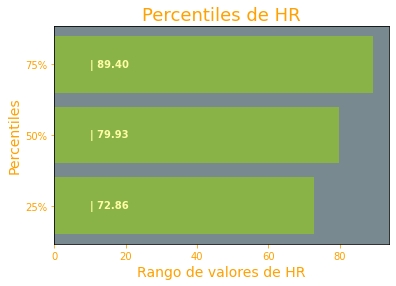

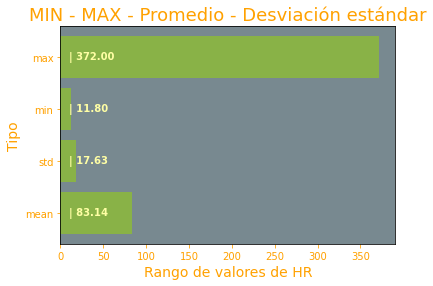

In [ ]:
# Preparamos los graficos

# Obtenemos percentiles
# Estiquetas
percentil_type = list(hr_characteristics[4:7])
# Valores
percentil_values = list(hr_values[4:7])
# Imprimimos datos
gp.inove_barh(x= percentil_values, y=percentil_type, tittle='Percentiles de HR', ylabel='Percentiles', xlabel='Rango de valores de HR')
print('\n \n')
# Obtenemos mínimo, máximo, promedio y desviación estándar
# Estiquetas
hr_statistics_types = list(hr_characteristics[1:4])
hr_statistics_types.append(hr_characteristics[7])
# Valores
hr_statistics_values = list(hr_values[1:4])
hr_statistics_values.append(hr_values[7])
# Imprimimos datos
gp.inove_barh(x= hr_statistics_values, y=hr_statistics_types, tittle='MIN - MAX - Promedio - Desviación estándar', ylabel='Tipo', xlabel='Rango de valores de HR')

# Procesar datos
<div align="center"><img src="https://lh3.googleusercontent.com/pw/ACtC-3ecH_bbd3CY23v8dqfIsuoE1FT7dDeRqxlG4Ti4RzKkOqAHMTD8ukvX7wx_G2PkKFQjNeoGGtL3xoqhCqfKCSdk1lE_2FuTiQaV2jDy3_fZeVbBxgEhtVwGnoLhBfQyb36KZxHPn0puUpJV825MBkQJ=w1366-h133-no?authuser=0" width="1000" align="middle"></div>

In [ ]:
# Establecemos parámetros de estres
def fix_stress_labels(df='',label_column='stress'):
    df['stress'] = np.where(df['stress']>=0.5, 1, 0)
    display(df["stress"].unique())
    return df
dataframe_hrv = fix_stress_labels(df=dataframe_hrv)

array([0, 1])

In [ ]:

def missing_values(df):
    df = df.reset_index()
    df = df.replace([np.inf, -np.inf], np.nan)
    df[~np.isfinite(df)] = np.nan
    # df.plot( y=["HR"])
    df['HR'].fillna((df['HR'].mean()), inplace=True)
    df['HR'] = signal.medfilt(df['HR'],13) 
    # df.plot( y=["HR"])
    df=df.fillna(value=df.mean())
    return df
dataframe_hrv = missing_values(dataframe_hrv)


# Explorar datos
<div align="center"><img src="https://lh3.googleusercontent.com/pw/ACtC-3ePJ3-PFgVLwddhdqRi7z7VRo8j3r6LBSRPzWNek5805rJeEdWJKIbAKGj133aGArHgu1oe8-IDj9ET8FtAW0R5GrUOcPzgG0nnUFhfIRyug0VQ_2DwNB_zmMuReBy60ExzOQprBc8us4HlthdvRtx6=w1366-h133-no?authuser=0" width="1000" align="middle"></div>

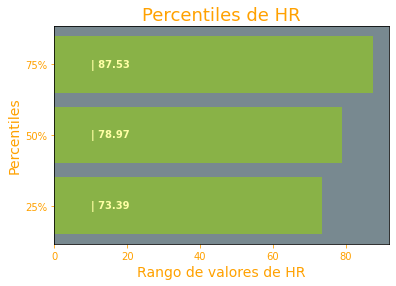

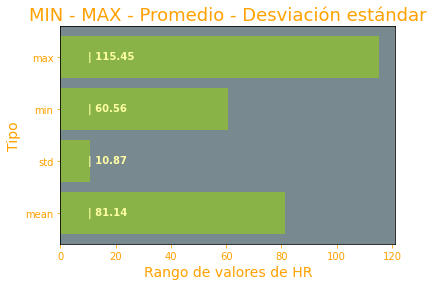

In [ ]:
# preparamos los datos para graficarlos
hr_values = dataframe_hrv[['HR']]
hr_characteristics = hr_values.describe()
hr_values = hr_characteristics['HR'].to_list()
hr_characteristics = hr_characteristics.index.to_list()

# Preparamos los graficos
# Obtenemos percentiles
percentil_type = list(hr_characteristics[4:7])
percentil_values = list(hr_values[4:7])
gp.inove_barh(x= percentil_values, y=percentil_type, tittle='Percentiles de HR', ylabel='Percentiles', xlabel='Rango de valores de HR')
print('\n \n')
# Obtenemos mínimo, máximo, promedio y desviación estándar
hr_statistics_types = list(hr_characteristics[1:4])
hr_statistics_types.append(hr_characteristics[7])
hr_statistics_values = list(hr_values[1:4])
hr_statistics_values.append(hr_values[7])
gp.inove_barh(x= hr_statistics_values, y=hr_statistics_types, tittle='MIN - MAX - Promedio - Desviación estándar', ylabel='Tipo', xlabel='Rango de valores de HR')

In [ ]:
# Presentamos los datos en formato de tabla
selected_x_columns = ['HR','interval in seconds','AVNN', 'RMSSD', 'pNN50', 'TP', 'ULF', 'VLF', 'LF', 'HF','LF_HF']
X = dataframe_hrv[selected_x_columns]
y = dataframe_hrv['stress']
display(X.describe())

,HR,interval in seconds,AVNN,RMSSD,pNN50,TP,ULF,VLF,LF,HF,LF_HF
count,4129.000000,4129.000000,4129.000000,4129.000000,4129.000000,4129.000000,4129.000000,4129.000000,4129.000000,4129.000000,4129.000000
mean,81.144252,0.788440,0.788020,0.027223,0.034246,0.060604,0.057902,0.000728,0.000003,0.000001,3.555695
std,10.871620,0.109768,0.109363,0.016964,0.025153,0.056901,0.057757,0.003194,0.000030,0.000010,0.244431
min,60.558824,0.527944,0.528170,0.000000,0.000000,0.000008,0.000000,0.000000,0.000000,0.000000,0.418526
25%,73.394737,0.718930,0.720548,0.013743,0.025641,0.019485,0.012480,0.000000,0.000000,0.000000,3.555695
50%,78.973684,0.789732,0.790125,0.022889,0.027027,0.047369,0.035371,0.000000,0.000000,0.000000,3.555695
75%,87.527778,0.869053,0.868135,0.043000,0.030303,0.100771,0.098881,0.000000,0.000000,0.000000,3.555695
max,115.446809,1.040088,1.038360,0.080981,0.257143,0.329891,0.329891,0.035841,0.000616,0.000261,9.117240


# Entrenar modelo
<div align="center"><img src="https://lh3.googleusercontent.com/pw/ACtC-3csSQnxbKYYltM7w3bryOXpVvhrxI8PZ-xHKtEleb8SiwPjx_vNiCIfYQUVVUtCUz5zyhyCGqCjj9mWlHcXqmSZpHL5lrQrCcnbg0tRQiWYmATPeAzVKVrQGCA22rH7R9QrQsOFjeXmw3z4a17k_GTn=w1366-h133-no?authuser=0" width="1000" align="middle"></div>

In [ ]:
def do_tpot(generations=5, population_size=10,X='',y=''):

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        train_size=0.80, test_size=0.20)

    tpot = TPOTClassifier(generations=generations, population_size=population_size, verbosity=2,cv=3)
    tpot.fit(X_train, y_train)
    print(tpot.score(X_test, y_test))
    tpot.export('tpot_pipeline.py')
    return tpot

tpot_classifer = do_tpot(generations=10, population_size=20,X=X,y=y)


Generation 1 - Current best internal CV score: 0.7366030881017257
Generation 2 - Current best internal CV score: 0.7387223735997578
Generation 3 - Current best internal CV score: 0.7387223735997578
Generation 4 - Current best internal CV score: 0.7438692098092643
Generation 5 - Current best internal CV score: 0.7438692098092643
Generation 6 - Current best internal CV score: 0.7505298213745081
Generation 7 - Current best internal CV score: 0.7505298213745081
Generation 8 - Current best internal CV score: 0.7505298213745081
Generation 9 - Current best internal CV score: 0.7505298213745081

Best pipeline: RandomForestClassifier(PolynomialFeatures(RobustScaler(RandomForestClassifier(RBFSampler(input_matrix, gamma=0.8), bootstrap=True, criterion=gini, max_features=0.5, min_samples_leaf=2, min_samples_split=5, n_estimators=100)), degree=2, include_bias=False, interaction_only=False), bootstrap=True, criterion=entropy, max_features=0.2, min_samples_leaf=7, min_samples_split=19, n_estimators=

In [ ]:

def plotFitBitReading(dfnewHRV='', predictor = "none",selected_x_columns=''):
    dfnewHRV = missing_values(dfnewHRV)
    dfnewPol = dfnewHRV[selected_x_columns].fillna(0)

    #print(dfnewPol.columns)
    #print(dfnewPol.shape)
    pred = predictor.predict_proba(dfnewPol)
    
    dfpred = pd.DataFrame(pred) 
    # dfpred.columns = [["FALSE","TRUE"]] <-- Otro bug 
    dfpred.columns = ["FALSE","TRUE"]  
    dfpred['stress'] = np.where(dfpred["TRUE"] > 0.5, 1, np.nan)

    
    dfnewHRV["stress"] = dfpred["stress"]
    dfnewHRV.loc[dfnewHRV["steps"] > 0, 'stress'] = np.nan
    #mark is to mark the RR peaks as stress
    dfnewHRV.loc[dfnewHRV["stress"] == 1, 'stress'] = dfnewHRV['interval in seconds'] 
    dfnewHRV.loc[dfnewHRV["steps"] > 0, 'moving'] = dfnewHRV['interval in seconds'] 
    dfnewHRV["minutes"] = (dfnewHRV['newtime']/60)/1000
    
    from itertools import cycle, islice
    my_colors = list(islice(cycle([gp.L_BLUE_DOTS, gp.L_RED, gp.L_YELOW, 'k']), None, len(dfnewHRV)))

    plot = dfnewHRV.plot(x="minutes", y=['interval in seconds',"stress", "moving"],color=my_colors)
    plot.set_facecolor(gp.PLOT_BKGROUND + 'aa') # Inove

    fig = plot.get_figure() 


# Validar modelo
<div align="center"><img src="https://lh3.googleusercontent.com/pw/ACtC-3cak4pQwIT8LrDUfrv0XXdf9MfEDbCytI3Yttzzd8BG0AyqJ74FpFe5kVMZ0UoKguSjr3-_qKe1Qg2eWEk5YalKmtcwGFV5OS2CmmoVsEPIRpUZeg4SzIDrcQDRTGNP-9RPT4q1VVXrHtCdCZDYrfgW=w1366-h133-no?authuser=0" width="1000" align="middle"></div>

In [ ]:
import glob

for filename in glob.iglob('dataset/**/*.csv', recursive=True):
    if 'dfnew' in filename:
        print(filename)

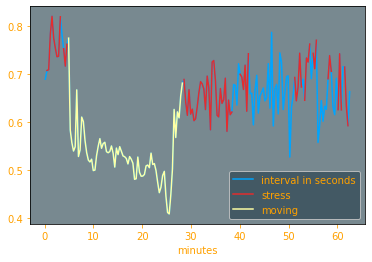

In [ ]:
dataset_path = '/content/Stress_classifier_with_AutoML_and_wearable_devices/dataset/Vikings/Female_24_years_old/dfnewHRV.csv'
input_df = pd.read_csv(dataset_path)
plotFitBitReading(input_df,tpot_classifer,selected_x_columns)

# Utilizar modelo
<div align="center"><img src="https://lh3.googleusercontent.com/pw/ACtC-3cCImYtu1CcKuITmTpV7hyJmrEt_8ADIqZiqlksAyNwCvcwR8sDZLQl54gmo4sobCgb3vpuzjWAFDkBh6cT33oBYTMJMyltD25Q8einZ37Gx_9gsCLI50iBX1wo3fz5c0BaedWiyJs3MdHotbxnkSjg=w1366-h133-no?authuser=0" width="1000" align="middle"
></div>

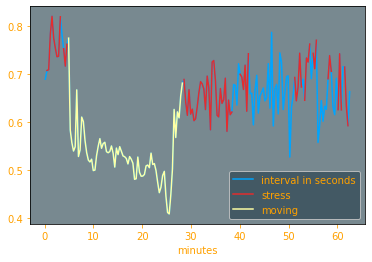

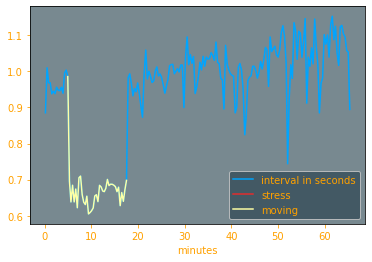

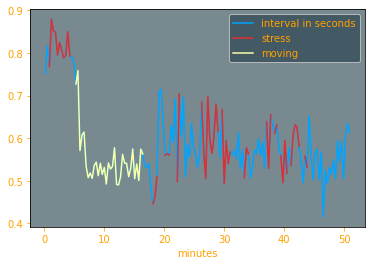

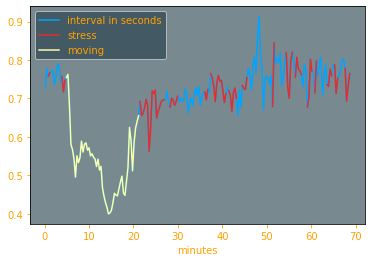

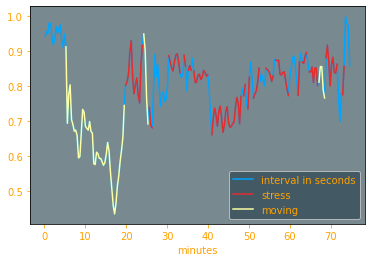

In [ ]:
input_df = pd.read_csv('/content/Stress_classifier_with_AutoML_and_wearable_devices/dataset/Vikings/Female_24_years_old/dfnewHRV.csv')
plotFitBitReading(input_df,tpot_classifer,selected_x_columns)
input_df = pd.read_csv('/content/Stress_classifier_with_AutoML_and_wearable_devices/dataset/Vikings/Female_33_years_old/dfnewHRV_Female_33_years_old_vikings.csv')
plotFitBitReading(input_df,tpot_classifer,selected_x_columns)
input_df = pd.read_csv('/content/Stress_classifier_with_AutoML_and_wearable_devices/dataset/Vikings/Male_21_years/dfnewHRV.csv')
plotFitBitReading(input_df,tpot_classifer,selected_x_columns)
input_df = pd.read_csv('/content/Stress_classifier_with_AutoML_and_wearable_devices/dataset/Vikings/Male_23_years_old/dfnewHRVMale_23_years_old.csv')
plotFitBitReading(input_df,tpot_classifer,selected_x_columns)
input_df = pd.read_csv('/content/Stress_classifier_with_AutoML_and_wearable_devices/dataset/Vikings/male_22years/dfnewHRVVIKINGSFULLSERIES.csv')
plotFitBitReading(input_df,tpot_classifer,selected_x_columns)

<div align="center"><img src="https://lh3.googleusercontent.com/pw/ACtC-3c0b9wdQXhFVvYu-h9-AsPEg621I8En-CINRW5eJhYJweohC0gQ-8j-ZftxoZ6TXZWQbFRoLxNCH_xLHjnEEUMMKg9k72CQU8Zyd2if6CFBPWV_8umCQXI543v6o1cOhk5001p-pKe8wIOb2eSa2KN7=w1366-h133-no?authuser=0" width="1000" align="middle"></div>
<hr>
<h5><a href="https://github.com/chriotte/Stress_classifier_with_AutoML_and_wearable_devices/blob/master/auto_ml_stress_simplified_notebook.ipynb"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/91/Octicons-mark-github.svg/1024px-Octicons-mark-github.svg.png" width="30" align="center"></a> 
Link al repositorio del autor
</h5>